In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline

from matplotlib import style
style.use(style.available[14])

In [2]:
%run run_gnode_mnist.py

[mnist_start: run_gnode_mnist.py:  71] WARNING: <module>(): Deleting Logs...


mode: GPU
{
  "resume": false, 
  "exp_name": "mnist_start", 
  "hyperparams": "hyperparams/mixed_mnist.py", 
  "weights": "iter", 
  "tensorboard": true, 
  "gpu": 1, 
  "delete": []
}
loading HP from file
importing hyperparams hyperparams.mixed_mnist



[mnist_start: gan.py:  24] INFO: __init__(): model constructor entered
[mnist_start: gan.py:  61] INFO: __init__(): model constructor created
[mnist_start: utils.py:  45] INFO: create_child_node(): Child Node node0 created from None


/data/project_skeleton/gan-tree/src/trainers


In [95]:
GNode.load('../experiments/exp20_mixed_mnist/best_node-10.pt', root)

<GNode[name=node0 id=0 parent_id=-1]>

In [89]:
tr.manual_seed(42)
if tr.cuda.is_available():
    tr.cuda.manual_seed_all(42)
X, L = dl.random_batch('train', 2018)

In [90]:
print X.shape, L.shape
digits = {i:[] for i in range(20)}
for x, l in zip(X, L):
    digits[l.item()].append(x[None, :, :, :])
for l in digits:
    digits[l] = tr.cat(digits[l])

torch.Size([2018, 1, 28, 28]) torch.Size([2018])


#### **Critic**

In [61]:
from models.images.classifier import MNISTCritic

In [62]:
critic = MNISTCritic(10)
critic.load_state_dict(tr.load('fashion_mnist_clf.pt'))

In [63]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [10]:
f = tr.distributions.MultivariateNormal(tr.zeros(100), tr.eye(100))
tsne = TSNE(2)
pca50 = PCA(50)
pca2 = PCA(2)

In [64]:
def interpolate(z1, z2, steps):
    lsp = tr.linspace(0, 1, steps)[:, None]
    return z1 + lsp * (z2 - z1)

In [65]:
from matplotlib import gridspec

In [66]:
def interpolate(z1, z2, steps=10):
    return z1 + np.linspace(0, 1, steps)[:, None] * (z2 - z1)



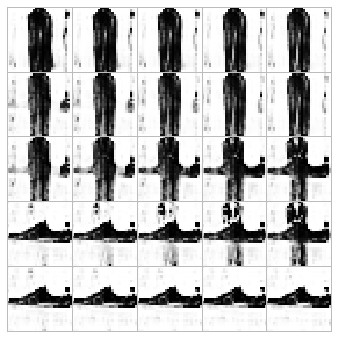

In [67]:
style.use(style.available[6])
from matplotlib import gridspec

d1 = 6
d2 = 9
steps = 25
n = 5

node = root

z1 = node.sample_z_batch()[0].cpu().numpy()
z2 = node.sample_z_batch()[0].cpu().numpy()

z_stream = interpolate(z1, z2, steps)
x_stream = node.gan.decode(z_stream.astype('float32'))
# z_rand = f.sample((100,))

# probs = critic.probs(tr.tensor(x_stream))
# x = x_stream
margin = 0.05

fig = plt.figure(figsize=(n, n))
gs = gridspec.GridSpec(n, n, fig, hspace=0.0, wspace=0.0)
gs.update(bottom=margin, left=margin, top=1 - margin, right=1 - margin)
ax = fig.subplots(n, n)

for i in range(n):
    for j in range(n):
        ax = plt.subplot(gs[i, j])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_yticks([])
        ax.set_xticks([])
        if i % 2 == 0:
            index = i*n + j
        else:
            index = i * n + n - j - 1
        img = x_stream[index, 0]
        ax.imshow(img)

fig.savefig('diagrams/mnist_concept_%d%d' % (d1, d2))

In [68]:
data = dl.data['train']
labels = dl.labels['train']

In [69]:
digits = {
    i:[] for i in range(20)
}

for i in range(data.shape[0]):
    l = labels[i].item()
    digits[l].append(data[i:i+1])
    
for i in range(20):
    digits[i] = tr.cat(digits[i])

In [70]:
from utils import tr_utils
from sklearn.mixture import GaussianMixture as GMM

In [71]:
def plot(z, margin=0.05, best_n=None):
    x = root.gan.decode(z)
    if best_n:
        probs = critic.probs(x).max(axis=-1)
#         print probs
        indices = np.argsort(probs)[-best_n:]
        x = x[indices]
    x = -x
    total = x.shape[0] * 1.0
    n = int(np.sqrt(total))
    while total % n > 0:
        n -= 1
    m = int(total / n)
    fig = plt.figure(figsize=(m, n))
    gs = gridspec.GridSpec(n, m, fig, hspace=0.0, wspace=0.0)
    gs.update(bottom=margin, left=margin, top=1 - margin, right=1 - margin)
    for i in range(n):
        for j in range(m):
            ax = plt.subplot(gs[i, j])
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_yticks([])
            ax.set_xticks([])
            index = i * m + ((1 - i % 2) * j + (i % 2) * (m - j - 1))
            ax.imshow(x[index, 0])
    return x

In [96]:
d = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

d1 = [0, 3, 8, 6, 9]
d2 = list(set(d) - set(d1))

d = d2

# d = [9]
# d = [3, 8]

# d = [1, 2, 4, 5, 7]
# d = [1, 2, 7]

# d = [0]
# d = [6]
# d = [9]

# d = [6]

all_digits = tr.cat([digits[i] for i in d])

perm = tr.randperm(all_digits.shape[0])[:1000]
x = all_digits[perm]
# z = root.sample_z_batch(1000)
z = root.gan.encode(x)

gmm = GMM(len(d))
gmm.fit(z)

z, l = gmm.sample(100)
z = tr.tensor(z, dtype=tr.float32)
print z.shape

# mu, cov = tr_utils.mu_cov(z)
# f = tr.distributions.MultivariateNormal(mu, cov, )

torch.Size([100, 100])


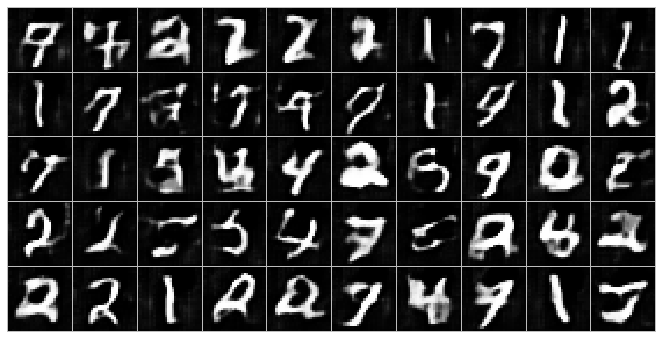

In [97]:
plot(z, best_n=50);

torch.Size([64, 100])


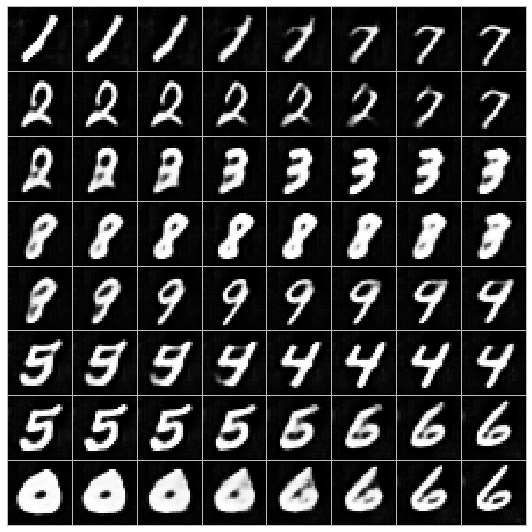

In [110]:
def interpolate(z1, z2, steps=10):
    return z1 + tr.linspace(0, 1, steps)[:, None] * (z2 - z1)

# d = [13, 18]
# d = [15, 17, 19, 18, 12, 14, 16, 12, 13, 11, 1, 7, 2, 3, 8, 9, 4, 5, 6, 0]
d = [1, 7, 2, 3, 8, 9, 4, 5, 6, 0]
# d = [15, 17, 19, 18, 12, 14, 16, 10, 12, 13, 11]
# d = [15, 17, 19, 18]
# d = [14, 16, 10, 12, 13, 11]
# d = [1, 7, 2, 3, 8, 9, 4, 5, 6, 0]
# d = [5, 6, 0, 8, 3, 9, 4]
# d = [5, 6, 0, 8, 3, 9, 4]
# d = [5, 6, 0, 8, 3]
# # d = [6, 6]
# d = [0, 8, 3]
# d = [8, 3]a
# d = [0, 0]
# d = [8, 8]
# d = [0, 0]
# d = [9, 4]
# d = [2, 7]
# d = [2, 7, 1]
# d = [6, 6]

# d = [15, 19, 17]
steps =8
n = 15

z = [root.pre_gmm_encode(digits[d[i]]) for i in range(len(d))]
r = [tr.randint(0, z[i].shape[0], (1,))[0].int() for i in range(len(d))]

z_stream = []
for i in range(len(d) - 1):
    seq = interpolate(z[i][[r[i]]], z[i+1][[r[i+1]]], steps)
#     print seq.shape
    if i == 0:
        z_stream.append(seq)
    else:
        z_stream.append(seq[1:])
z_stream = tr.cat(z_stream)
print z_stream.shape
x_stream = root.gan.decode(z_stream)
# z_rand = f.sample((100,))

probs = critic.probs(tr.tensor(x_stream))
x = x_stream
margin = 0.05

plot(z_stream);

# fig.savefig('diagrams/mnist_concept_%d%d' % (d1, d2))

TypeError: %d format: a number is required, not list

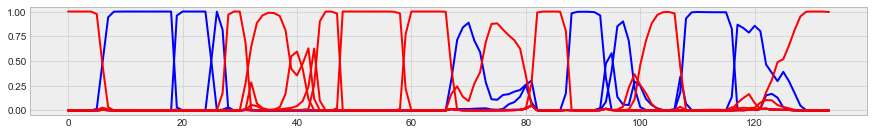

In [94]:
fig = plt.figure(figsize=(15, 2))
ax = fig.add_subplot(111)
ax.plot(probs[:, d1], c='blue')
ax.plot(probs[:, d2], c='red')
ax.figure.savefig('diagrams/mnist_concept_probs_%d%d' % (d1, d2))

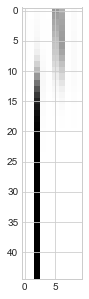

In [201]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.imshow(probs);

In [22]:
# print x1.shape
z1 = root.gan.encoder(tr.rand(12, 1, 28, 28))
print ''
z1 = root.gan.encoder(tr.rand(11, 1, 28, 28))

In [80]:
from sklearn import mixture

In [82]:
a = np.random.normal(0, 1, (1000, 100)) +  3.0
b = np.random.normal(0, 1, (1000, 100)) - 3.0

A = np.concatenate(np.ones(1000))

In [83]:
gmm = mixture.GaussianMixture(2)

In [84]:
gmm.fit(A)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [129]:
gmm.predict_proba(np.zeros((10, 100)) + 0.0542518 )

array([[0.50000777, 0.49999223],
       [0.50000777, 0.49999223],
       [0.50000777, 0.49999223],
       [0.50000777, 0.49999223],
       [0.50000777, 0.49999223],
       [0.50000777, 0.49999223],
       [0.50000777, 0.49999223],
       [0.50000777, 0.49999223],
       [0.50000777, 0.49999223],
       [0.50000777, 0.49999223]])

Started tensorboard at http://10.24.32.52:8006


In [5]:
from matplotlib import gridspec

In [ ]:
gridspec.GridSpec()